# Bike sharing model building

**Author:** Tamas Horvath (txttw)

## Business objective

Management want to understand how exactly the demands vary with different features (independent vaibles). They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. In addition the model will be a good way for management to understand the demand dynamics of a new market.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

## Data overview

In [58]:
# Read data set csv
bike = pd.read_csv('data.csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [59]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Regression models are sensitive to missing or invalid data, but info shows there are no missing data in the data set, so data imputation or removal is not needed here.

In [60]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Visual Data check

Check if numerical variables are linearly related to target variable (cnt)

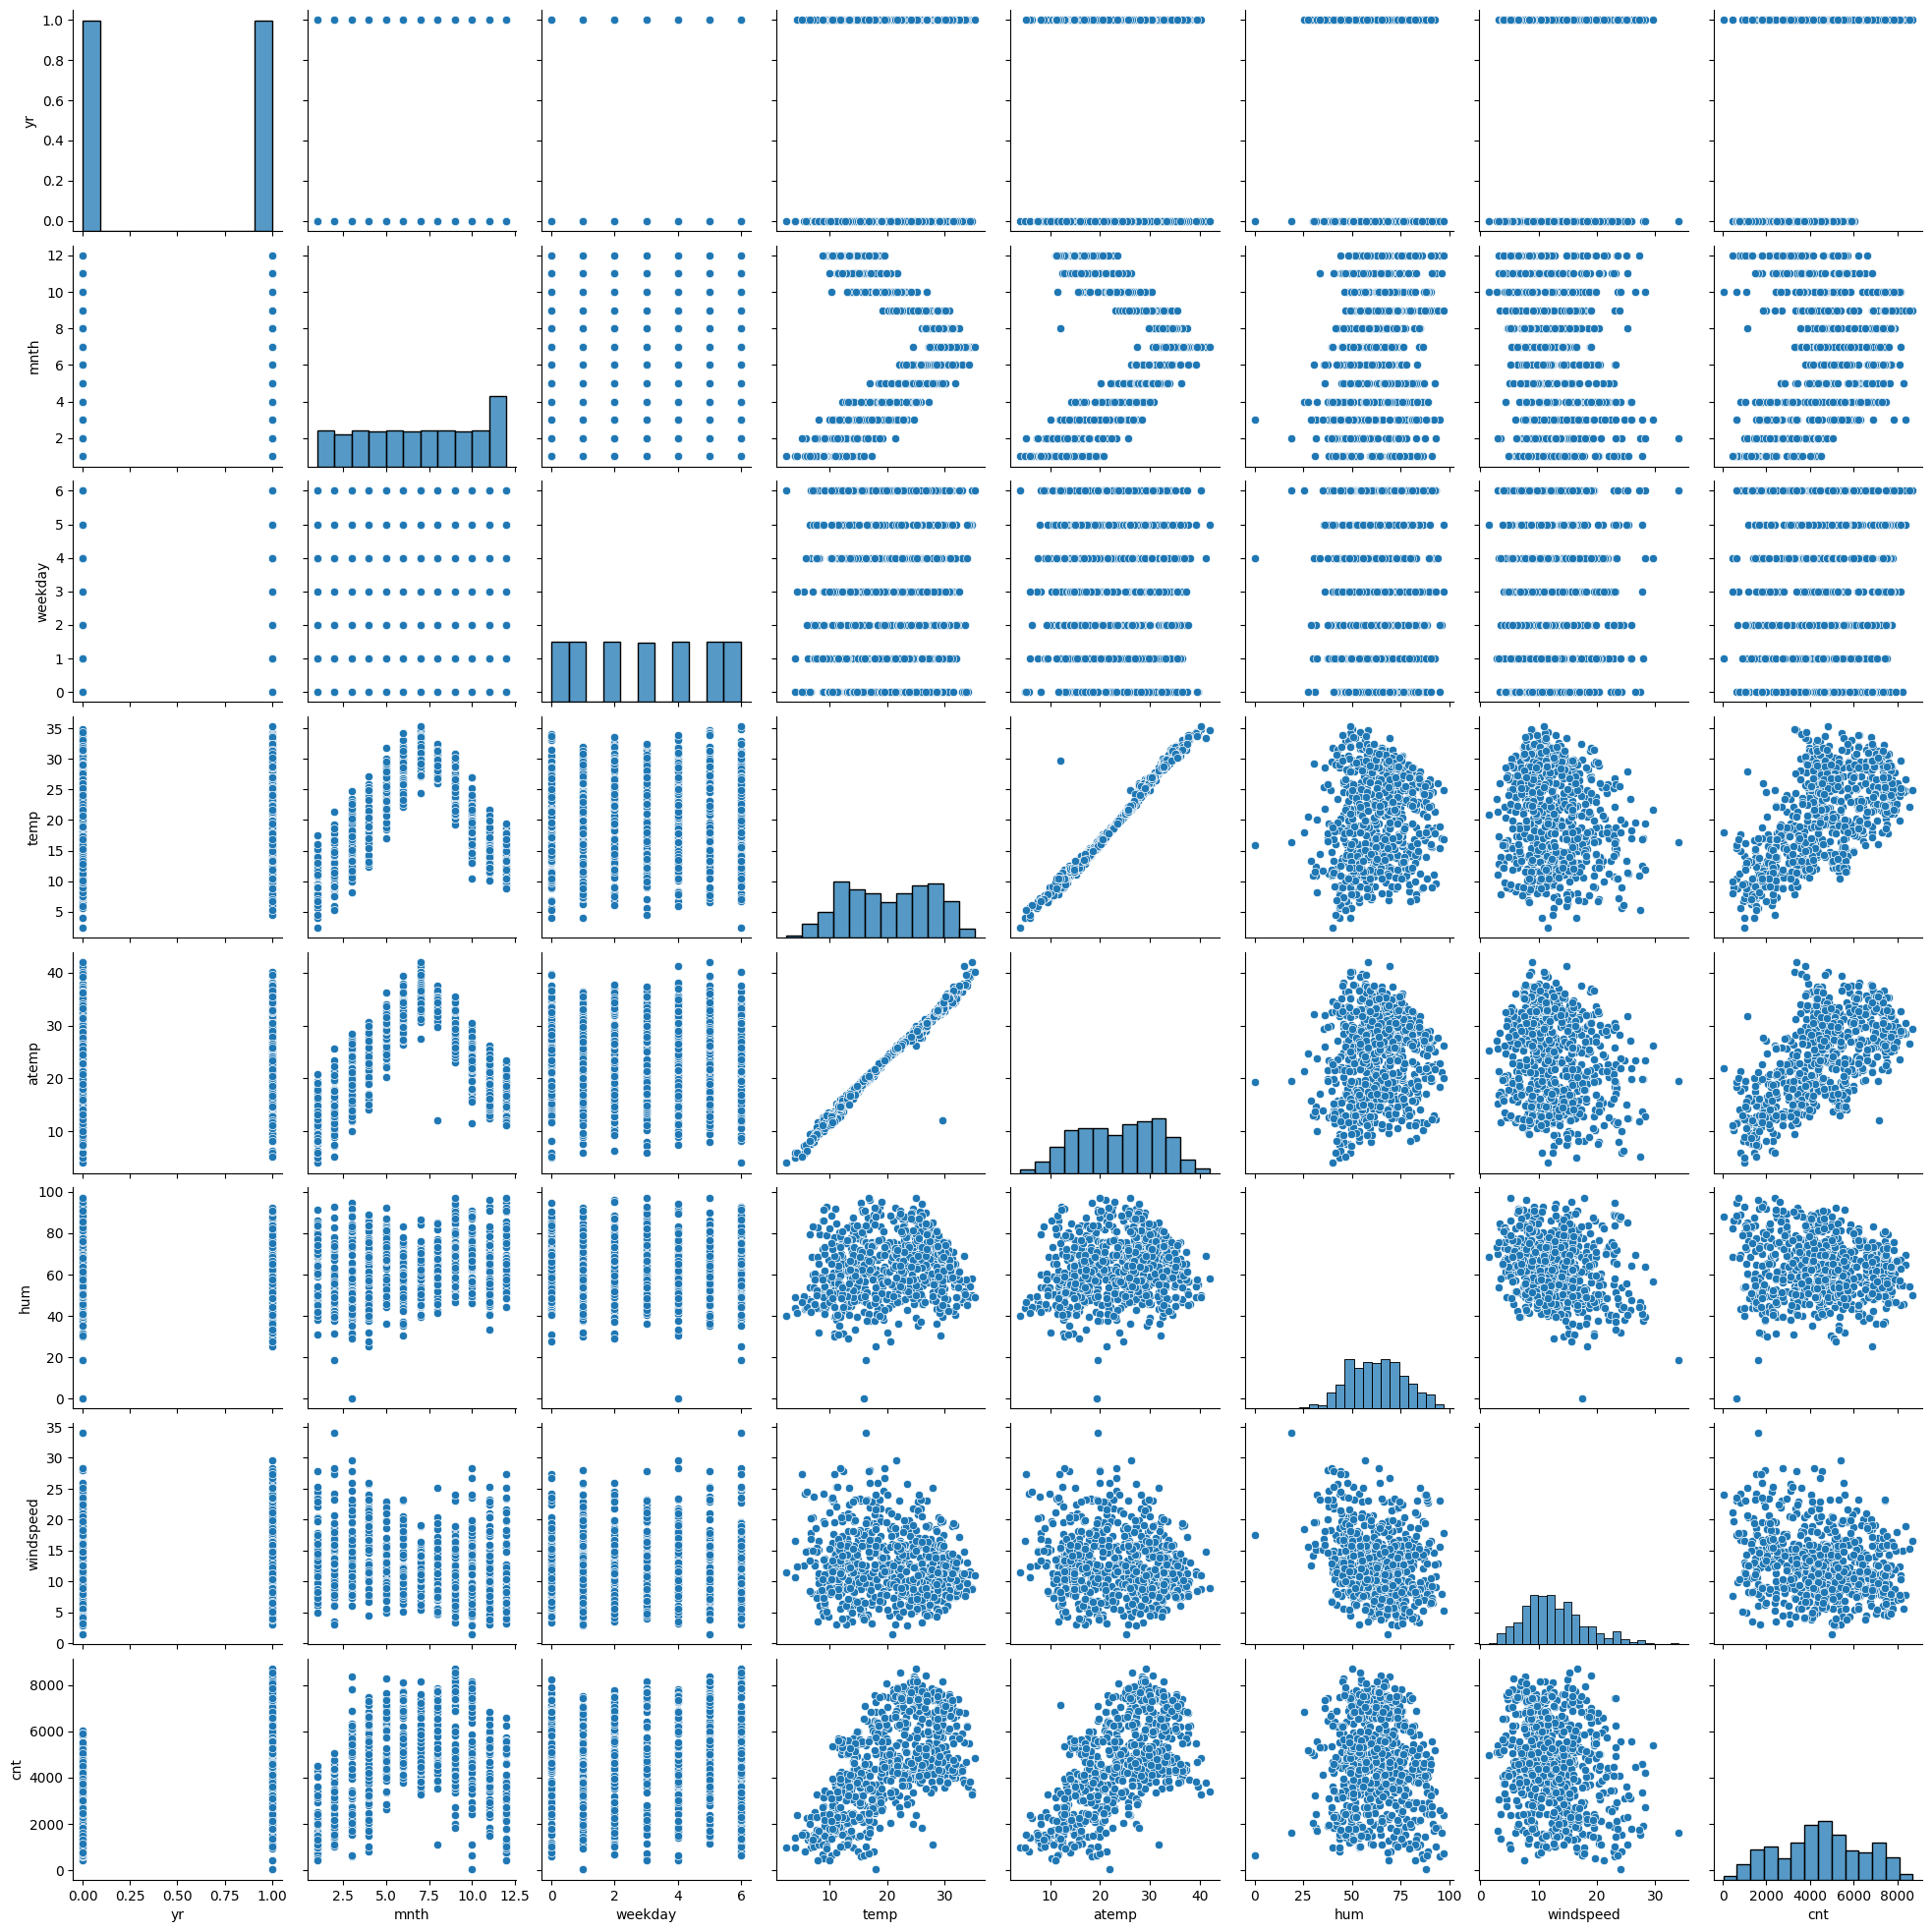

In [61]:
# visualize continious variables
numerical_vars = ['yr', 'mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(bike.loc[:,numerical_vars])
plt.show()

The plot shows that year, month, temp, atemp, hum, windspeed has some relationship with target wariable.It is also clear that temp and atemp has strong linear relationship one should be eliminated from the model.

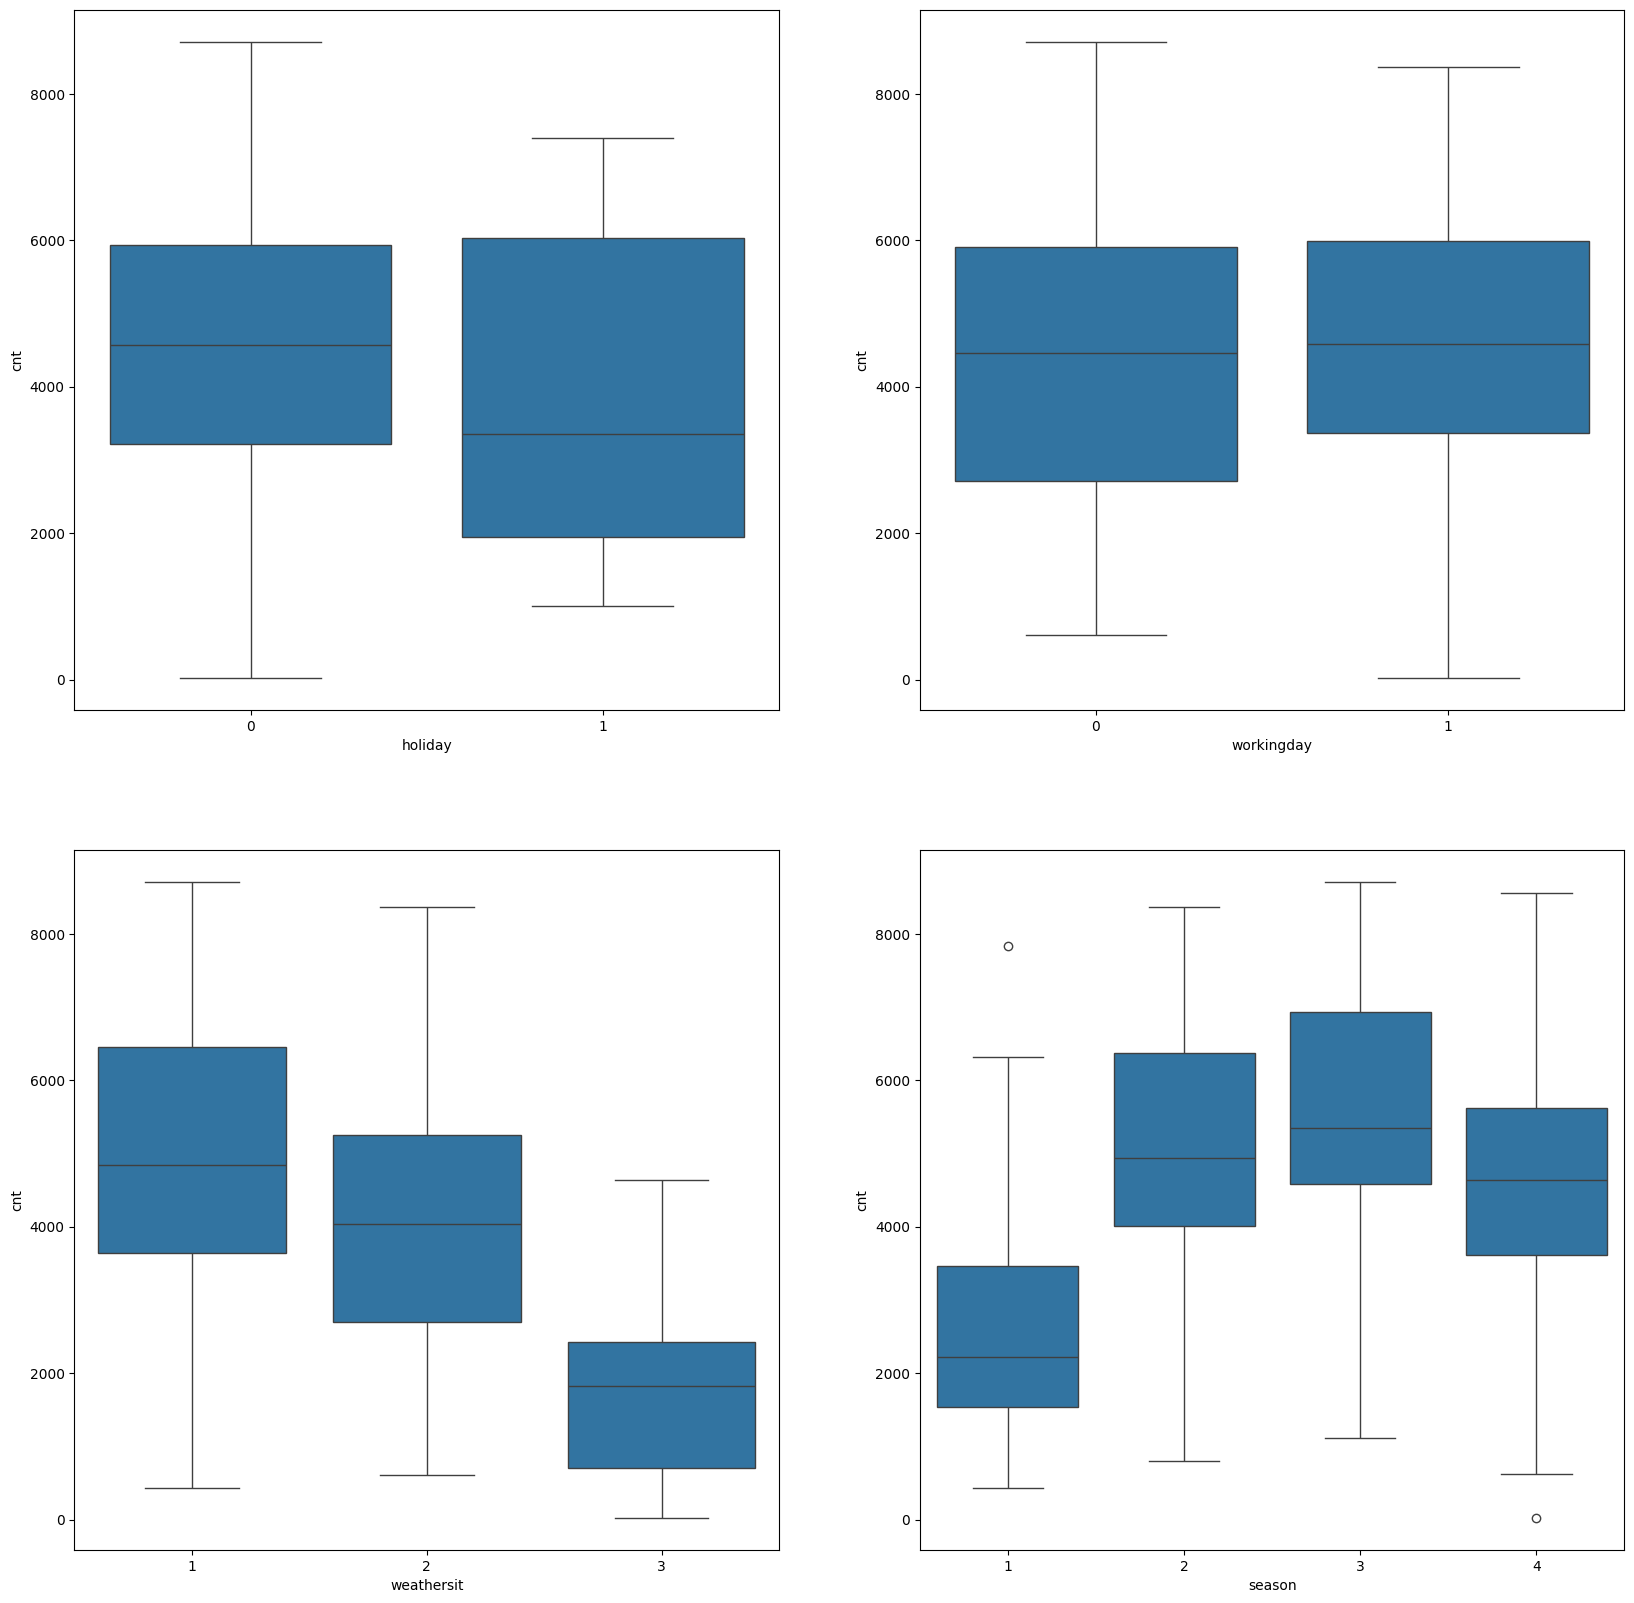

In [62]:
# visualize categorical variables
plt.figure(figsize=(20,20))
categorical_vars = ['holiday', 'workingday', 'weathersit', 'season']
for i,x in enumerate(categorical_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=x, y='cnt', data=bike)


Holidays have a negative effect on the rentals with higher uncertainty (higher variance). Mist has slight and rain has significant negative effect that coincides with domain specific knowledge. Data shows that in spring the daily rentals are significantly lower. Correlation between seasons and weather expected (from domain spec. knowledge).

## Data preparation

Some of the variables are categorical variables but given as Numbers (continious vars.) - ie. season, weathersit - it is better to convert them to categorical variables. Year (yr), however could represent a continum as demand could increase over time as this time of transportation becomes more and more popular over time.

In [63]:
# Drop record index (instant) it is an auto-increment id
bike = bike.drop('instant', axis=1)

# The exact date of the rental (dteday) is redundant here because we have year, mounth, day of the week
# and other date related columns. It can be eliminated based on data/domain knowledge
# But if it is not the case a multicollinearity test could be performed 
bike = bike.drop('dteday', axis=1)

# encode season (1:spring, 2:summer, 3:fall, 4:winter)
# to 3 dummy binary variables (spring, summer, fall)
bike['spring'] = bike.apply(lambda r: int(r.season == 1) , axis=1)
bike['summer'] = bike.apply(lambda r: int(r.season == 2) , axis=1)
bike['fall'] = bike.apply(lambda r: int(r.season == 3) , axis=1)

# drop season
bike = bike.drop('season', axis=1)

# Dataset column weathersit does not contain value 4
print(bike['weathersit'].unique())

# There is no point training a model based on empty variable
# but it is important to note if later prediction data sets does have 
# it should be eliminated otherwise those points could end up colliding with default (clear)

# encode weathersit to 2 dummy variables
bike['mist'] = bike.apply(lambda r: int(r.weathersit == 2) , axis=1)
bike['rain'] = bike.apply(lambda r: int(r.weathersit == 3) , axis=1)

# drop weathersit
bike = bike.drop('weathersit', axis=1)

[2 1 3]


The target (dependent) variable is the number of total rental bikes (cnt) including casual and registered. Now, there is no need to build separate models for casual and registered so those columns can be dropped.

In [64]:
#drop casual, registered columns
bike = bike.drop(['casual', 'registered'], axis=1) # axis=1 column

### Data Normalization
Min-Max scaling is used to provide an easier interpretation of the fitted model and coefficients.

In [65]:
# split to train and test before scaling
df_train, df_test = train_test_split(bike, train_size=0.70, random_state=100)

In [66]:
scaler = MinMaxScaler()
# scale only numeric variables (0, 1 vars are ok)
# yr seems to be binary but it is not
# happens to be only 2 years from the start of data collection that represented by 0,1
num_vars = ['yr', 'mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
# scale
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

## Training the Model
Check correlation between variables and target variable (cnt)

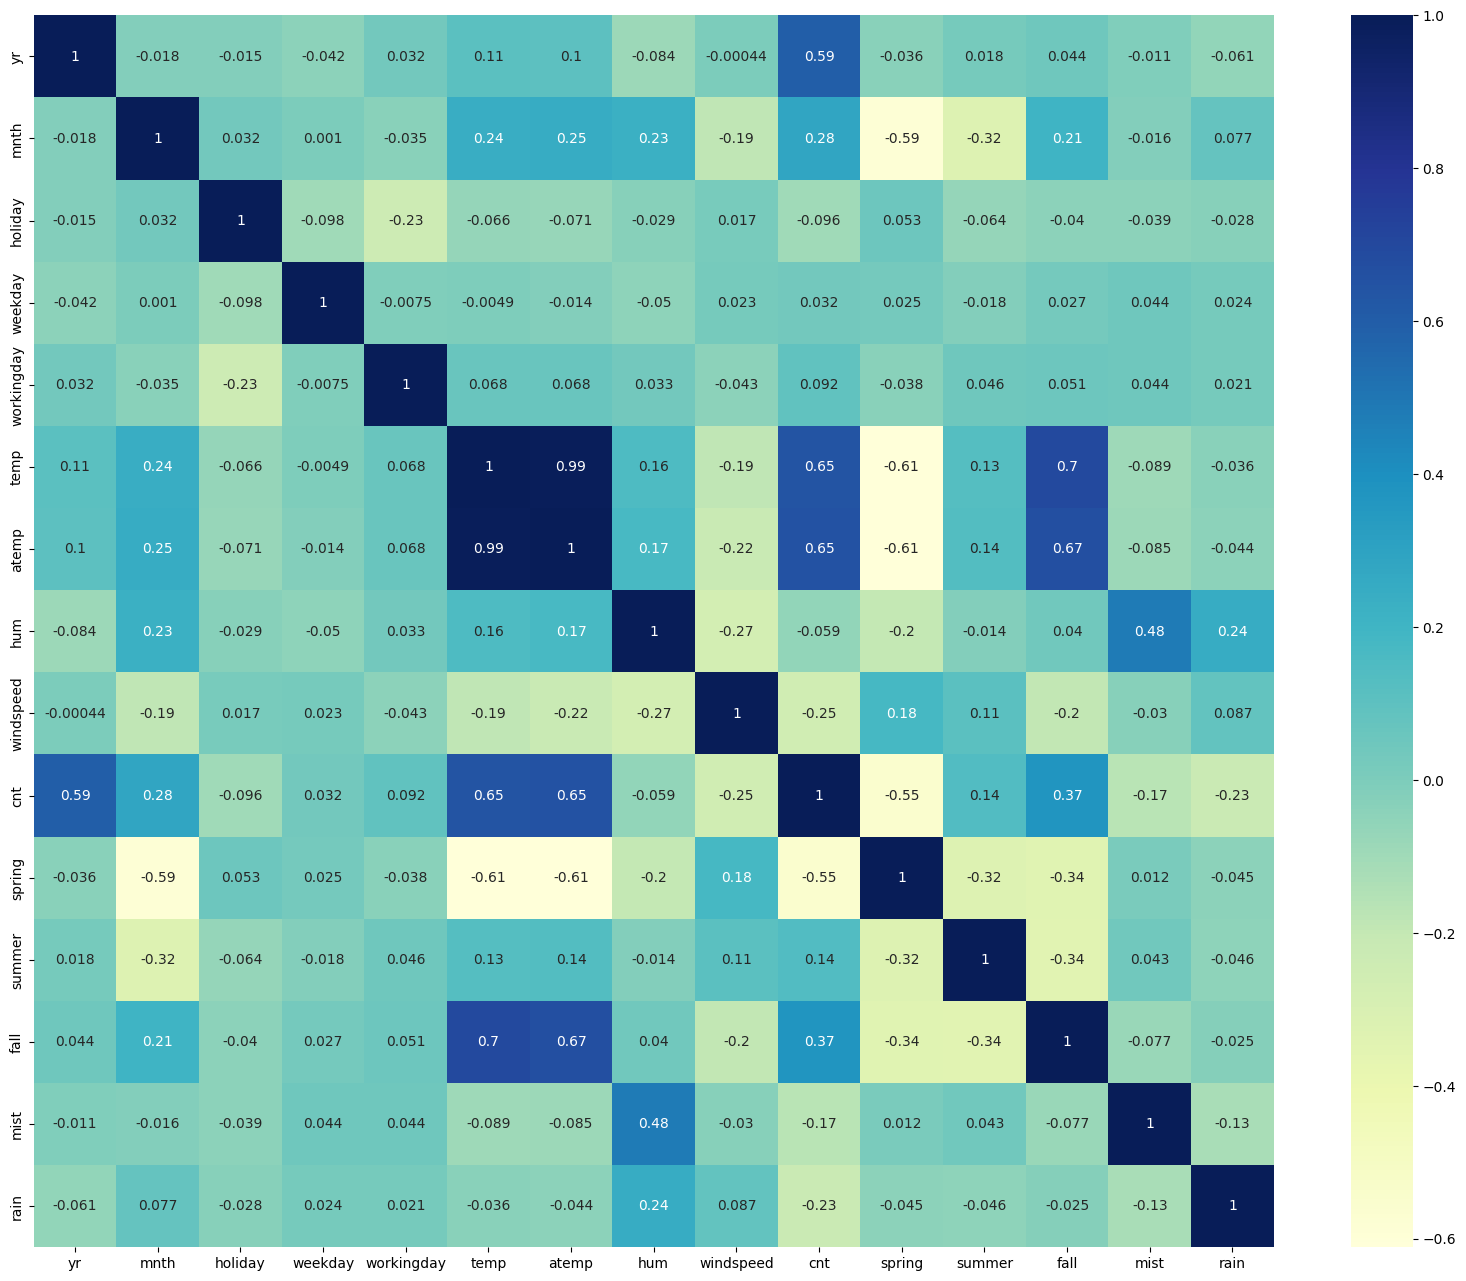

In [67]:
plt.figure(figsize=(20,16))
sns.heatmap(df_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

temp/atemp, yr has strong positive correlation and spring, rain has reasonable negative correlation with target variable.

Manually selecting the variables for the model is feasible because the total number of variables are less not tto high. 
But we are going tomak a semi-automatic (number of features are predefined but actual feature selection is done by RFE) approach for demonstration purpuses and later use cross-validation to check our results.

From the plotted correlation matrix there are reasonably correlated variables like temp/atemp, temp/seasons, rain/humidity, rain/mnth etc.  
Start RFE with 12 variables.

In [68]:
y_train = df_train.pop('cnt') # pops cnt
X_train = df_train; # remaining

In [69]:
# Functions for later use
def rfe_LR(X, y, n):
    # Use LinearRegression as estimator
    lm = LinearRegression()
    lm.fit(X, y)    
    # run RFE
    rfe = RFE(lm, n_features_to_select=n) 
    rfe.fit(X_train, y_train)
    return rfe

def train_model(X, y):
    X_c = sm.add_constant(X)
    lm = sm.OLS(y, X_c).fit()
    return lm

def calc_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif


In [70]:
# select n features
n_features = 12

# Run RFE with LR
rfe = rfe_LR(X_train, y_train, n_features)

# show RFE result
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', np.True_, np.int64(1)),
 ('mnth', np.False_, np.int64(3)),
 ('holiday', np.True_, np.int64(1)),
 ('weekday', np.True_, np.int64(1)),
 ('workingday', np.False_, np.int64(2)),
 ('temp', np.True_, np.int64(1)),
 ('atemp', np.True_, np.int64(1)),
 ('hum', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('spring', np.True_, np.int64(1)),
 ('summer', np.True_, np.int64(1)),
 ('fall', np.True_, np.int64(1)),
 ('mist', np.True_, np.int64(1)),
 ('rain', np.True_, np.int64(1))]

In [71]:
# kept columns
kept_vars = X_train.columns[rfe.support_]
print(list(kept_vars))

['yr', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'mist', 'rain']


In [72]:
# Build model
X_train_rfe = X_train[kept_vars]
lm = train_model(X_train_rfe, y_train)
print(lm.summary())

# calculate VIF
vif = calc_vif(X_train_rfe)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     204.8
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          1.38e-183
Time:                        16:59:15   Log-Likelihood:                 493.47
No. Observations:                 510   AIC:                            -960.9
Df Residuals:                     497   BIC:                            -905.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3476      0.031     11.061      0.0

atemp is not significant based on P value that is not surprising based on the correlation matrix.
Remove atemp.

In [73]:
# remove atemp
kept_vars = kept_vars.drop('atemp')

# Build model
X_train_m = X_train[kept_vars]
lm = train_model(X_train_m, y_train)
print(lm.summary())

# calculate VIF
vif = calc_vif(X_train_m)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     223.8
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          9.89e-185
Time:                        16:59:16   Log-Likelihood:                 493.37
No. Observations:                 510   AIC:                            -962.7
Df Residuals:                     498   BIC:                            -911.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3488      0.031     11.151      0.0

temp and hum have high VIF, it indicates multicollinearity. hum is less significant so drop it first and check the new model.

In [74]:
# drop hum and check the result
kept_vars = kept_vars.drop('hum')

# Build model
X_train_m = X_train[kept_vars]
lm = train_model(X_train_m, y_train)
print(lm.summary())

# calculate VIF
vif = calc_vif(X_train_m)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     240.5
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          1.15e-183
Time:                        16:59:17   Log-Likelihood:                 488.01
No. Observations:                 510   AIC:                            -954.0
Df Residuals:                     499   BIC:                            -907.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2719      0.021     13.149      0.0

temp still has high VIF. Based on P value drop summer. summer and temp are correlated it should reduce VIF of temp.

In [75]:
# drop summer and check the result
kept_vars = kept_vars.drop('summer')

# Build model
X_train_m = X_train[kept_vars]
lm = train_model(X_train_m, y_train)
print(lm.summary())

# calculate VIF
vif = calc_vif(X_train_m)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     262.6
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          3.71e-183
Time:                        16:59:19   Log-Likelihood:                 483.92
No. Observations:                 510   AIC:                            -947.8
Df Residuals:                     500   BIC:                            -905.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2749      0.021     13.217      0.0

temp still has high VIF. holiday has the largest P value but from domain specific knowledge and the correlation matrix it is unlikely to be the cause of hight temp VIF. From boxplot and correlation matrix spring is the strongest predictor from the season category. And seasons are correlated to temp, therfore keep spring and drop fall.

In [76]:
# drop fall and check the result
kept_vars = kept_vars.drop('fall')

# Build model
X_train_m = X_train[kept_vars]
lm = train_model(X_train_m, y_train)
print(lm.summary())

# calculate VIF
vif = calc_vif(X_train_m)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     286.7
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          1.46e-181
Time:                        16:59:20   Log-Likelihood:                 477.24
No. Observations:                 510   AIC:                            -936.5
Df Residuals:                     501   BIC:                            -898.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3005      0.020     15.165      0.0

Interpretation: Temperature has a positive effet while rain has a strong negative effect on the bike rentals. In spring a drop expected in the numbers. Wind also affect rentals negativelly. From the data (var: yr) it is clear that bike rental becomes more and more popular.

The model is able to describe 82% of the variance of the training set. All the variables are significant. R2 adjusted is very close to R2 so the number of variables are acceptable. Multicollinearity is within acceptable limit (<5), therefore **this is the final model**.

## Residual Analysis

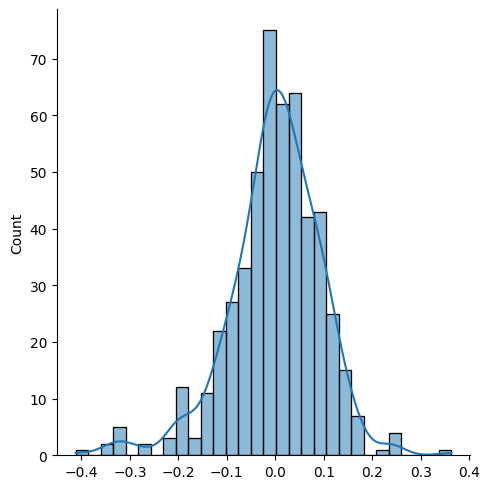

In [77]:
# add const
X_c = sm.add_constant(X_train_m)

# make prediction
y_train_pred = lm.predict(X_c)

# calculate residuals
res = y_train - y_train_pred;

# display residual distribution
sns.displot(res, kde=True)

Residuals are normally distributed

### Evaluate the model on the test data set

In [78]:
# scale, use scaler trained with train set
df_test[num_vars] = scaler.transform(df_test[num_vars])

y_test = df_test.pop('cnt') # pops cnt
X_test = df_test; # remaining

# keep vars present in the final model
X_test = X_test[kept_vars]

# add const to test set
X_test_sm = sm.add_constant(X_test)

# predict using test data
y_test_pred = lm.predict(X_test_sm)

# eval, r-squared on the test [-1, 1]
r2 = r2_score(y_true=y_test, y_pred=y_test_pred)

# mean squared error
mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred)

print(r2)
print(mse)

0.8014452148533421
0.009493753994546886


Test and train R2 score difference is within 5%. **The modell is accepted.**

We will use cross-validation to check our results

In [84]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

min_features_to_select = 4  # Minimum number of features to consider
lm = LinearRegression()
cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=lm,
    step=1,
    cv=cv,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=6,
)
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LinearRegression(), min_features_to_select=4, n_jobs=6,
      scoring='r2')

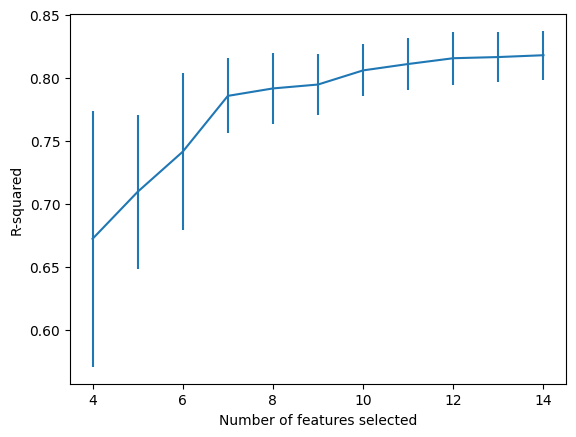

In [85]:
cv_results = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
df_results = pd.DataFrame(cv_results)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("R-squared")
plt.errorbar(
    x=df_results["n_features"],
    y=df_results["mean_test_score"],
    yerr=df_results["std_test_score"],
)
plt.show()

The abeve selected model is congruent with cross validation results.